In [53]:
import numpy as np
import pandas as pd
import pyranges as pr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset

from gene_expression_prediction.data_loader import BedReader
from gene_expression_prediction.data_loader import BigWigReader
from gene_expression_prediction.data_loader import GeneReader
from gene_expression_prediction.data_processor import CellLine
from gene_expression_prediction.data_processor import FeatureNames
from gene_expression_prediction.data_processor import ProcessedFeatures
from gene_expression_prediction.data_processor import process_cell_line
from gene_expression_prediction.data_processor import save_processed_features
from gene_expression_prediction.data_processor import visualize_gene_data

## Work Package 1.1 - Modeling Choices & Data Pre-processing

In [54]:
# TODO:
# Load your feature (bed and/or bigwig and/or fasta) and target files (tsv) here.
# Decide which features to use for training. Feel free to process them however you need.

# NOTE:
# bed and bigwig files contain signals of all chromosomes (including sex chromosomes).
# Training and validation split based on chromosomes has been done for you.
# However, you can resplit the data in any way you want.

# ---------------------------INSERT CODE HERE---------------------------
data_path = "/workspaces/Gene-Expression-Prediction/data"
info_data = GeneReader(data_path)
bed_data = BedReader(data_path)
bigwig_data = BigWigReader(data_path)

PROMOTER_WINDOW_SIZE = 5000
BIN_SIZE = 100
DISTAL_WINDOW_SIZE = 50_000
SAMPLE_N = 1000

# Takes around 20 minutes to run
cell_line_x1 = process_cell_line(
    cell_line=CellLine.X1,
    gene_reader=info_data,
    bed_reader=bed_data,
    bigwig_reader=bigwig_data,
    promoter_window_size=PROMOTER_WINDOW_SIZE,
    bin_size=BIN_SIZE,
    distal_window_size=DISTAL_WINDOW_SIZE,
    sample_n=SAMPLE_N,
)
save_processed_features(
    cell_line_x1, "/workspaces/Gene-Expression-Prediction/data/processed_data_x1"
)

cell_line_x2 = process_cell_line(
    cell_line=CellLine.X2,
    gene_reader=info_data,
    bed_reader=bed_data,
    bigwig_reader=bigwig_data,
    promoter_window_size=PROMOTER_WINDOW_SIZE,
    bin_size=BIN_SIZE,
    distal_window_size=DISTAL_WINDOW_SIZE,
    sample_n=SAMPLE_N,
)
save_processed_features(
    cell_line_x2, "/workspaces/Gene-Expression-Prediction/data/processed_data_x2"
)

cell_line_x3 = process_cell_line(
    cell_line=CellLine.X3,
    gene_reader=info_data,
    bed_reader=bed_data,
    bigwig_reader=bigwig_data,
    promoter_window_size=PROMOTER_WINDOW_SIZE,
    bin_size=BIN_SIZE,
    distal_window_size=DISTAL_WINDOW_SIZE,
    sample_n=None,
)
save_processed_features(
    cell_line_x3, "/workspaces/Gene-Expression-Prediction/data/processed_data_x3"
)


combined_tensor = np.concatenate(
    [cell_line_x1.promoter_signal_tensor, cell_line_x2.promoter_signal_tensor], axis=0
)

annotations_x1 = cell_line_x1.gene_annotations.copy()
annotations_x2 = cell_line_x2.gene_annotations.copy()
annotations_x1["gene_name"] = annotations_x1["gene_name"] + "_x1"
annotations_x2["gene_name"] = annotations_x2["gene_name"] + "_x2"
combined_annotations = pd.concat([annotations_x1, annotations_x2], ignore_index=True)

distal_x1 = cell_line_x1.distal_peak_features.copy()
distal_x2 = cell_line_x2.distal_peak_features.copy()
distal_x1.index = distal_x1.index + "_x1"
distal_x2.index = distal_x2.index + "_x2"
combined_distal = pd.concat([distal_x1, distal_x2])

targets_x1 = cell_line_x1.target_expression.copy()
targets_x2 = cell_line_x2.target_expression.copy()
targets_x1.index = targets_x1.index + "_x1"
targets_x2.index = targets_x2.index + "_x2"
combined_targets = pd.concat([targets_x1, targets_x2])

combined_features = ProcessedFeatures(
    gene_annotations=combined_annotations,
    promoter_signal_tensor=combined_tensor,
    distal_peak_features=combined_distal,
    target_expression=combined_targets,
)
# ----------------------------------------------------------------------

All required data paths have been successfully validated.
Sampling 1000 genes from the original 16284.


Distal BED Features:   0%|          | 0/7 [00:00<?, ?it/s]

Promoter Signal Tensor:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling 1000 genes from the original 16284.


Distal BED Features:   0%|          | 0/7 [00:00<?, ?it/s]

Promoter Signal Tensor:   0%|          | 0/1000 [00:00<?, ?it/s]

Distal BED Features:   0%|          | 0/7 [00:00<?, ?it/s]

Promoter Signal Tensor:   0%|          | 0/1984 [00:00<?, ?it/s]

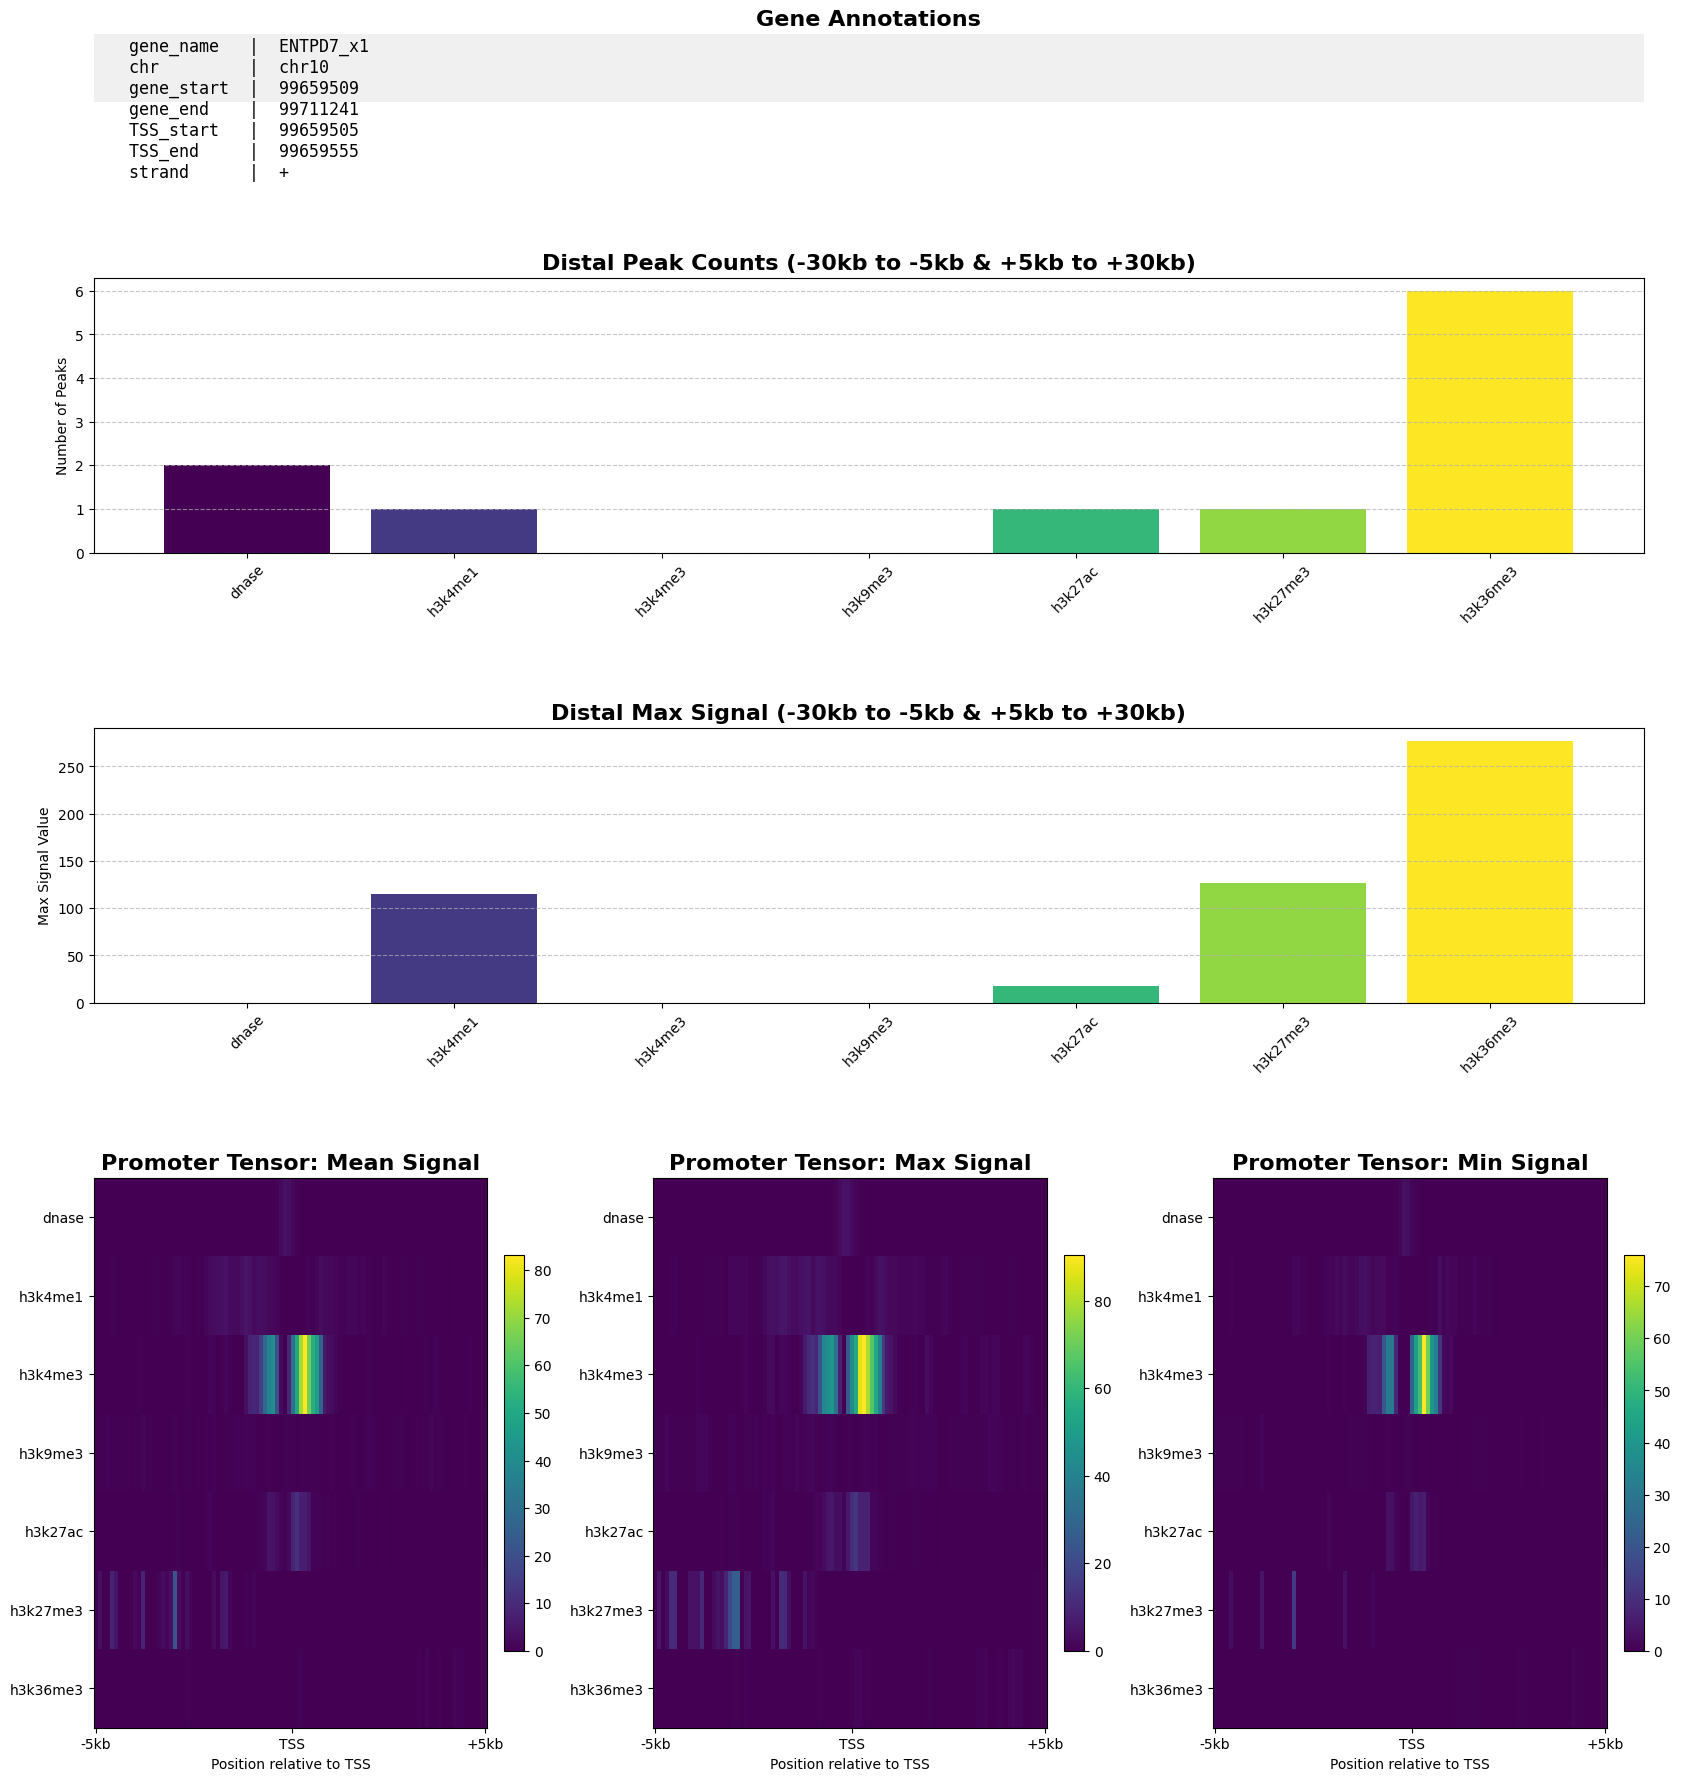

In [55]:
visualize_gene_data(
    combined_features.get_gene_data_by_name("ENTPD7_x1"),
    promoter_window_size=5000,
    bin_size=100,
)
# combined_features.gene_annotations
# cell_line.distal_peak_features
# cell_line.promoter_signal_tensor

## Work Package 1.2 - Model Building

In [61]:
# TODO:
# Select the best model to predict gene expression from the obtained features in WP 1.1.
# pytorch_dataset.py


class GeneExpressionDataset(Dataset):
    """
    PyTorch Dataset for the hybrid gene expression prediction task.

    Handles multiple inputs:
    1. The promoter signal tensor for the CNN branch.
    2. The distal peak features for the dense branch.
    """

    def __init__(self, processed_features: ProcessedFeatures):
        """
        Initializes the Dataset with all required feature sets.
        """
        if processed_features.target_expression is None:
            raise ValueError(
                "Cannot create a training/validation dataset without target expression values."
            )

        self.promoter_tensor = torch.from_numpy(
            processed_features.promoter_signal_tensor
        ).float()

        distal_df = processed_features.distal_peak_features.fillna(0.0)
        self.distal_features = torch.from_numpy(distal_df.values).float()

        targets_np = processed_features.target_expression.fillna(0.0).values
        self.targets = torch.from_numpy(targets_np).float()

        # Raw shape: (n_genes, n_bins, n_features, n_channels)
        # Permute to: (n_genes, n_features, n_channels, n_bins)
        self.promoter_tensor = self.promoter_tensor.permute(0, 2, 3, 1)

        # (n_genes, n_features * n_channels, n_bins)
        n_genes, n_features, n_channels, n_bins = self.promoter_tensor.shape
        self.promoter_tensor = self.promoter_tensor.reshape(
            n_genes, n_features * n_channels, n_bins
        )

        print(f"Dataset created. Promoter tensor shape: {self.promoter_tensor.shape}")
        print(f"Dataset created. Distal features shape: {self.distal_features.shape}")

    def __len__(self) -> int:
        """Returns the total number of samples (genes) in the dataset."""
        return len(self.targets)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves one sample from the dataset, including all feature sets.

        Args:
            idx: The integer index of the sample to retrieve.

        Returns:
            A tuple of tensors: (promoter_data, distal_data, target).
        """
        promoter_data = self.promoter_tensor[idx]
        distal_data = self.distal_features[idx]
        target = self.targets[idx]

        return promoter_data, distal_data, target


class HybridCNN(nn.Module):
    """
    A hybrid 1D CNN and Dense network for predicting gene expression.
    - The CNN branch processes promoter signals (from BigWig).
    - The Dense branch processes distal peak features (from BED).
    """

    def __init__(
        self, n_bins: int, n_features: int, n_channels: int, n_distal_features: int
    ):
        """
        Initializes the hybrid architecture.

        Args:
            n_bins: The number of genomic bins in the promoter tensor.
            n_features: The number of chromatin features.
            n_channels: The number of channels per feature (e.g., 2 for mean, max).
            n_distal_features: The number of engineered features from BED files.
        """
        super().__init__()

        in_channels = n_features * n_channels
        self.conv1 = nn.Conv1d(
            in_channels=in_channels, out_channels=64, kernel_size=7, padding="same"
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=5, padding="same"
        )
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        cnn_output_size = (n_bins // 4) * 128

        self.distal_fc1 = nn.Linear(n_distal_features, 64)
        self.distal_bn1 = nn.BatchNorm1d(64)
        distal_output_size = 64

        combined_input_size = cnn_output_size + distal_output_size
        self.head_fc1 = nn.Linear(combined_input_size, 256)
        self.head_dropout = nn.Dropout(0.4)
        self.head_fc2 = nn.Linear(256, 1)

    def forward(self, promoter_x: torch.Tensor, distal_x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass for the hybrid model.

        Args:
            promoter_x: The promoter signal tensor for the CNN branch.
                        Shape: (batch_size, n_features * n_channels, n_bins)
            distal_x: The distal peak features for the dense branch.
                      Shape: (batch_size, n_distal_features)

        Returns:
            The final predicted gene expression value(s). Shape: (batch_size,)
        """
        cnn_out = self.pool1(F.relu(self.bn1(self.conv1(promoter_x))))
        cnn_out = self.pool2(F.relu(self.bn2(self.conv2(cnn_out))))
        cnn_out = torch.flatten(
            cnn_out, 1
        )

        distal_out = F.relu(
            self.distal_bn1(self.distal_fc1(distal_x))
        )

        combined = torch.cat(
            [cnn_out, distal_out], dim=1
        )

        x = F.relu(self.head_fc1(combined))
        x = self.head_dropout(x)
        x = self.head_fc2(x)

        x = F.relu(x)
        
        return x.squeeze(1)

# ----------------------------------------------------------------------

In [62]:
def train_and_evaluate(
    combined_features: ProcessedFeatures,
    model: nn.Module,
    device: torch.device,
    epochs: int,
    batch_size: int,
    learning_rate: float,
    num_workers: int = 0,
):
    """
    Handles the full training and validation pipeline for the hybrid model.
    """

    dataset_size = len(combined_features.target_expression)
    indices = list(range(dataset_size))
    train_indices, val_indices = train_test_split(
        indices, test_size=0.2, random_state=42
    )

    print(f"Combined dataset size: {dataset_size}")
    print(f"Training set size:   {len(train_indices)}")
    print(f"Validation set size: {len(val_indices)}")

    full_dataset = GeneExpressionDataset(combined_features)
    
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    pin_memory = device.type == "cuda"
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for promoter_inputs, distal_inputs, targets in train_loader:
            promoter_inputs, distal_inputs, targets = (
                promoter_inputs.to(device),
                distal_inputs.to(device),
                targets.to(device),
            )
            optimizer.zero_grad()
            outputs = model(promoter_inputs, distal_inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * promoter_inputs.size(0)

        avg_train_loss = running_loss / len(train_dataset)

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for promoter_inputs, distal_inputs, targets in val_loader:
                promoter_inputs, distal_inputs, targets = (
                    promoter_inputs.to(device),
                    distal_inputs.to(device),
                    targets.to(device),
                )
                outputs = model(promoter_inputs, distal_inputs)
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        spearman_corr, _ = spearmanr(all_targets, all_preds)

        print(
            f"Epoch {epoch + 1:02}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Spearman: {spearman_corr:.4f}"
        )

    return model

In [63]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

N_BINS = (2 * PROMOTER_WINDOW_SIZE) // BIN_SIZE
N_FEATURES = len(FeatureNames)
N_CHANNELS = 3
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_WORKERS = 2
MODEL_SAVE_PATH = "/workspaces/Gene-Expression-Prediction/data/saved_model/hybrid_cnn_model.pth"

model = HybridCNN(
    n_bins=N_BINS,
    n_features=N_FEATURES,
    n_channels=N_CHANNELS,
    n_distal_features=combined_features.distal_peak_features.shape[1],
)

trained_model = train_and_evaluate(
    combined_features=combined_features,
    model=model,
    device=DEVICE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    num_workers=NUM_WORKERS,
)
torch.save(trained_model.state_dict(), MODEL_SAVE_PATH)

Using device: cpu
Combined dataset size: 2000
Training set size:   1600
Validation set size: 400
Dataset created. Promoter tensor shape: torch.Size([2000, 21, 100])
Dataset created. Distal features shape: torch.Size([2000, 14])


Epoch 01/20 | Train Loss: 175707.9149 | Val Spearman: 0.6197
Epoch 02/20 | Train Loss: 174378.4713 | Val Spearman: 0.6451
Epoch 03/20 | Train Loss: 172882.6095 | Val Spearman: 0.6703
Epoch 04/20 | Train Loss: 171060.6915 | Val Spearman: 0.6849
Epoch 05/20 | Train Loss: 168962.7708 | Val Spearman: 0.6932
Epoch 06/20 | Train Loss: 167378.5092 | Val Spearman: 0.6981
Epoch 07/20 | Train Loss: 165561.7549 | Val Spearman: 0.6995
Epoch 08/20 | Train Loss: 164036.3824 | Val Spearman: 0.7003
Epoch 09/20 | Train Loss: 163285.4884 | Val Spearman: 0.7052
Epoch 10/20 | Train Loss: 160642.2271 | Val Spearman: 0.7066
Epoch 11/20 | Train Loss: 159552.7495 | Val Spearman: 0.7072
Epoch 12/20 | Train Loss: 158285.1121 | Val Spearman: 0.7075
Epoch 13/20 | Train Loss: 158513.1288 | Val Spearman: 0.6982
Epoch 14/20 | Train Loss: 155572.7725 | Val Spearman: 0.6978
Epoch 15/20 | Train Loss: 156624.0614 | Val Spearman: 0.7007
Epoch 16/20 | Train Loss: 155019.3739 | Val Spearman: 0.7101
Epoch 17/20 | Train Loss

## Work Package 1.3 - Prediction on Test Data (Evaluation Metric)

In [64]:
# TODO:
# Using the model trained in WP 1.2, make predictions on the test data (chr 1 of cell line X3).
# Store predictions in a variable called "pred" which is a numpy array.

pred = None
# ---------------------------INSERT CODE HERE---------------------------

class TestDataset(Dataset):
    def __init__(self, processed_features: ProcessedFeatures):
        self.promoter_tensor = torch.from_numpy(processed_features.promoter_signal_tensor).float()
        self.distal_features = torch.from_numpy(processed_features.distal_peak_features.values).float()
        
        # --- Data Shape Transformation for CNN input ---
        self.promoter_tensor = self.promoter_tensor.permute(0, 2, 3, 1)
        n_genes, n_features, n_channels, n_bins = self.promoter_tensor.shape
        self.promoter_tensor = self.promoter_tensor.reshape(n_genes, n_features * n_channels, n_bins)
        
    def __len__(self):
        return len(self.promoter_tensor)
        
    def __getitem__(self, idx):
        return self.promoter_tensor[idx], self.distal_features[idx]

print("--- Loading trained model and preparing for inference ---")
inference_model = HybridCNN(
    n_bins=N_BINS,
    n_features=N_FEATURES,
    n_channels=N_CHANNELS,
    n_distal_features=combined_features.distal_peak_features.shape[1]
).to(DEVICE)

inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

inference_model.eval()
print("Model loaded and set to evaluation mode.")

cell_line_x3.distal_peak_features = cell_line_x3.distal_peak_features.reindex(
    cell_line_x3.gene_annotations['gene_name']
)

test_dataset = TestDataset(cell_line_x3)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_WORKERS
)

test_genes = cell_line_x3.gene_annotations["gene_name"].values

pred = None
# ---------------------------INSERT CODE HERE---------------------------

print(f"\n--- Generating predictions for {len(test_genes)} test genes ---")
all_test_preds = []
with torch.no_grad(): # Disable gradient calculations for speed
    for promoter_inputs, distal_inputs in test_loader:
        # Move input data to the same device as the model
        promoter_inputs = promoter_inputs.to(DEVICE)
        distal_inputs = distal_inputs.to(DEVICE)
        
        # Get model outputs
        outputs = inference_model(promoter_inputs, distal_inputs)
        
        # Move predictions to the CPU and add to our list
        all_test_preds.extend(outputs.cpu().numpy())

# Convert the list of predictions into a single numpy array
pred = np.array(all_test_preds)
# ----------------------------------------------------------------------

# Check if "pred" meets the specified constrains
assert isinstance(pred, np.ndarray), "Prediction array must be a numpy array"
assert np.issubdtype(pred.dtype, np.number), "Prediction array must be numeric"
assert pred.shape[0] == len(test_genes), (
    "Each gene should have a unique predicted expression"
)

--- Loading trained model and preparing for inference ---
Model loaded and set to evaluation mode.

--- Generating predictions for 1984 test genes ---


#### Store Predictions in the Required Format

In [65]:
# Store predictions in a ZIP.
# Upload this zip on the project website under "Your submission".
# Zip this notebook along with the conda environment (and README, optional) and upload this under "Your code".
save_dir = "/workspaces/Gene-Expression-Prediction/data/output"
file_name = "gex_predicted.csv"  # PLEASE DO NOT CHANGE THIS
zip_name = "Tokar_David_Project1.zip"
save_path = f"{save_dir}/{zip_name}"
compression_options = {"method": "zip", "archive_name": file_name}

submission_df = pd.DataFrame({
    "gene_name": test_genes,
    "gex_predicted": pred
})

compression_options = {"method": "zip", "archive_name": file_name}

submission_df.to_csv(
    save_path,
    index=False,
    compression=compression_options
)
print(f"File saved to: {save_path}")
print("\nPreview of the first 5 rows of the submission file:")
print(submission_df.head())

File saved to: /workspaces/Gene-Expression-Prediction/data/output/Tokar_David_Project1.zip

Preview of the first 5 rows of the submission file:
    gene_name  gex_predicted
0       CAPN9       0.000000
1        ILF2      63.961761
2  ST6GALNAC5       0.000000
3  MROH7-TTC4       0.000000
4        AGO4      30.470169
